## Main Objective
The main objective is to develop a Book Recommendation System based on ratings and content information.  
A Book Recommendation System is a data-driven application that suggests books to users based on their preferences and behaviour.   
It aims to enhance user experience by providing personalized book recommendations, thereby increasing user engagement and satisfaction.   

### Data Understanding
The dataset has the following features:
1. **bookID**: A unique identifier for each book.
2. **title**: The title of the book.
3. **authors**: The author(s) of the book.
4. **average_rating**: The average rating of the book, indicating user satisfaction with the book.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [4]:
dataset = pd.read_csv("datasets/books_data.csv")

In [5]:
dataset.head()

,bookID,title,authors,average_rating
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78


In [6]:
dataset.isnull().sum()

bookID            0
title             0
authors           0
average_rating    0
dtype: int64

In [7]:
dataset.shape

(11127, 4)

In [28]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   bookID          11127 non-null  int64 
 1   title           11127 non-null  object
 2   authors         11127 non-null  object
 3   average_rating  11127 non-null  object
dtypes: int64(1), object(3)
memory usage: 347.8+ KB


In [29]:
# Convert 'average_rating' to a numeric data type
dataset['average_rating'] = pd.to_numeric(dataset['average_rating'], errors='coerce')

In [32]:
# Keep only rows where 'average_rating' contains valid numeric values
df_cleaned = dataset[dataset['average_rating'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]

### Exploratory Data Analysis
#### How is the overall distribution of average ratings across all books?

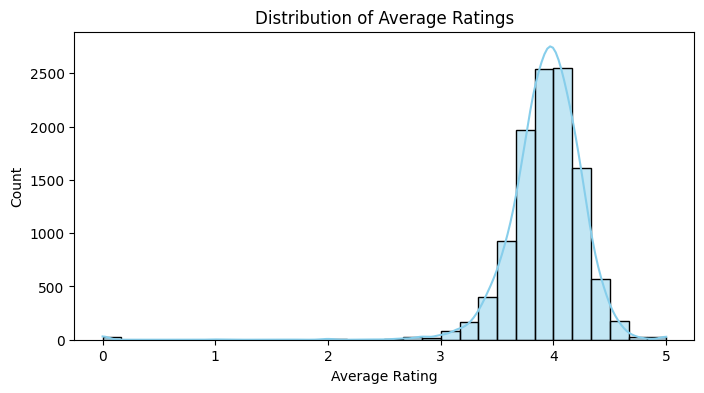

In [35]:
plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned['average_rating'], bins=30, kde=True, color='skyblue')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.title('Distribution of Average Ratings')
plt.show()

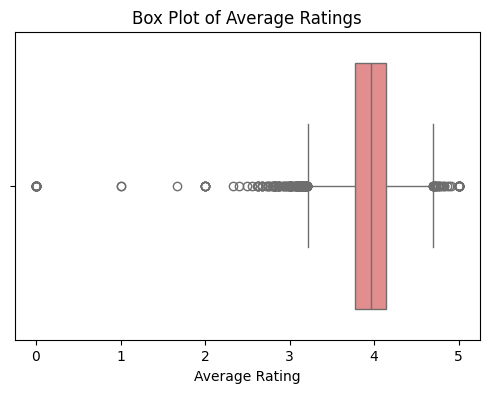

In [36]:
# Box plot
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_cleaned['average_rating'], color='lightcoral')
plt.xlabel("Average Rating")
plt.title("Box Plot of Average Ratings")
plt.show()

> TThe left skew suggests that fewer books received extremely low ratings (0–2.5), implying that users tend to rate books positively more often than negatively. This can indicate a bias in user ratings, people who dislike a book might not rate it at all.  
Outliers from 0 to 3 may represent books with low popularity, controversial books, or books with fewer reviews. Since the range from 4.6 to 5 contains outliers, it means a small group of books is consistently rated highly, which could be useful for identifying top recommendations.

#### Which books stand out as exceptionally high or low in rating, and what unique characteristics (e.g., title patterns or specific authors) do they share?

In [37]:
# Find max and min rating values
max_rating = df_cleaned["average_rating"].max()
min_rating = df_cleaned["average_rating"].min()

# Get all books with the highest rating
highest_rated_books = df_cleaned[df_cleaned["average_rating"] == max_rating]

# Get all books with the lowest rating
lowest_rated_books = df_cleaned[df_cleaned["average_rating"] == min_rating]

In [38]:
print(f"Number of books with highest rating {max_rating} is: {highest_rated_books.shape[0]}")
print(f"Number of books with lowest rating {min_rating} is: {lowest_rated_books.shape[0]}")

Number of books with highest rating 5.0 is: 22
Number of books with lowest rating 0.0 is: 25


In [39]:
highest_rated_books.head()

,bookID,title,authors,average_rating
624,2034,Comoediae 1: Acharenses/Equites/Nubes/Vespae/P...,Aristophanes/F.W. Hall/W.M. Geldart,5.0
786,2560,Willem de Kooning: Late Paintings,Julie Sylvester/David Sylvester,5.0
855,2843,Literature Circle Guide: Bridge to Terabithia:...,Tara MacCarthy,5.0
1243,4287,Middlesex Borough (Images of America: New Jersey),Middlesex Borough Heritage Committee,5.0
4126,14741,Zone of the Enders: The 2nd Runner Official St...,Tim Bogenn,5.0


In [40]:
lowest_rated_books.head()

,bookID,title,authors,average_rating
265,799,Out to Eat London 2002 (Lonely Planet Out to Eat),Lonely Planet/Mark Honan,0.0
375,1302,Juiced Official Strategy Guide,Doug Walsh,0.0
987,3351,Open City 6: The Only Woman He Ever Left,Open City Magazine/James Purdy/Daniel Pinchbec...,0.0
2532,9337,How To Meditate: An Anthology Of Talks On Medi...,Frederick P. Lenz,0.0
2533,9338,Insights: Talks On The Nature Of Existence,Frederick P. Lenz,0.0


#### Are certain authors consistently appearing in the highest or lowest-rated books?

In [41]:
# Count appearances of authors in each group
high_authors_count = highest_rated_books["authors"].value_counts()
low_authors_count = lowest_rated_books["authors"].value_counts()

In [42]:
# Display results
print("Authors appearing most in highest-rated books:")
high_authors_count.head(5)

Authors appearing most in highest-rated books:


authors
NOT A BOOK                             2
Aristophanes/F.W. Hall/W.M. Geldart    1
Ross Garnaut                           1
Sheri Rose Shepherd                    1
James E. Campbell                      1
Name: count, dtype: int64

In [43]:
print("Authors appearing most in lowest-rated books:")
low_authors_count.head(5)

Authors appearing most in lowest-rated books:


authors
Frederick P. Lenz             2
Lonely Planet/Mark Honan      1
Apollodorus/Richard Wagner    1
Warren G. Bennis              1
James Craig Holte             1
Name: count, dtype: int64

> All the authors amongst top rating books are unique ones!  
> Only 'Frederick P.Lenz' have been amongst the lowest rating authors twice! Others have only appeared once!

#### Are there common words or phrases among top-rated books?

In [44]:
# Function to clean and tokenize titles
def tokenize_title(title):
    title = str(title).lower()  # Convert to lowercase
    title = re.sub(r'[\(\)]', '', title)  # Remove parentheses
    title = re.sub(r'/', ' ', title)  # Replace slashes with space
    title = re.sub(r'[^a-z\s]', '', title)  # Remove any remaining non-alphabetic characters
    words = title.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return words


In [45]:
# Apply tokenization to top-rated book titles
# Make a copy to avoid SettingWithCopyWarning
highest_rated_books = highest_rated_books.copy()
highest_rated_books['title_tokens'] = highest_rated_books['title'].apply(tokenize_title)

In [46]:
highest_rated_books.head()

,bookID,title,authors,average_rating,title_tokens
624,2034,Comoediae 1: Acharenses/Equites/Nubes/Vespae/P...,Aristophanes/F.W. Hall/W.M. Geldart,5.0,"[comoediae, acharenses, equites, nubes, vespae..."
786,2560,Willem de Kooning: Late Paintings,Julie Sylvester/David Sylvester,5.0,"[willem, de, kooning, late, paintings]"
855,2843,Literature Circle Guide: Bridge to Terabithia:...,Tara MacCarthy,5.0,"[literature, circle, guide, bridge, terabithia..."
1243,4287,Middlesex Borough (Images of America: New Jersey),Middlesex Borough Heritage Committee,5.0,"[middlesex, borough, images, america, new, jer..."
4126,14741,Zone of the Enders: The 2nd Runner Official St...,Tim Bogenn,5.0,"[zone, enders, nd, runner, official, strategy,..."


In [21]:
# Flatten list of all words in top-rated books
all_words = [word for tokens in highest_rated_books['title_tokens'] for word in tokens]

In [22]:
# Count word frequency
word_freq = Counter(all_words)

In [23]:
# Display the most common words
print("Most common words in top-rated books:")
print(word_freq.most_common(20))  # Show top 20 most frequent words

Most common words in top-rated books:
[('literature', 3), ('paintings', 2), ('guide', 2), ('america', 2), ('new', 2), ('color', 2), ('theory', 2), ('goon', 2), ('show', 2), ('volume', 2), ('fallen', 2), ('critical', 2), ('commentary', 2), ('nicholas', 2), ('evans', 2), ('comoediae', 1), ('acharenses', 1), ('equites', 1), ('nubes', 1), ('vespae', 1)]


#### Are there common words or phrases among low-rated books?

In [24]:
# Apply tokenization to top-rated book titles
# Make a copy to avoid SettingWithCopyWarning
lowest_rated_books = lowest_rated_books.copy()
lowest_rated_books['title_tokens'] = lowest_rated_books['title'].apply(tokenize_title)

In [25]:
all_words_lowest_rated = [word for tokens in lowest_rated_books['title_tokens'] for word in tokens]

In [26]:
# Count word frequency
word_freq_lowest = Counter(all_words_lowest_rated)

In [27]:
print("Most common words in top-rated books:")
print(word_freq_lowest.most_common(20))  # Show top 20 most frequent words

Most common words in top-rated books:
[('guide', 3), ('eat', 2), ('talks', 2), ('meditation', 2), ('american', 2), ('apollodori', 2), ('night', 2), ('fantastic', 2), ('london', 1), ('lonely', 1), ('planet', 1), ('juiced', 1), ('official', 1), ('strategy', 1), ('open', 1), ('city', 1), ('woman', 1), ('ever', 1), ('left', 1), ('meditate', 1)]


#### What is the frequency distribution of books per author, and which authors are most prominent in the dataset?

In [48]:
author_counts = df_cleaned.groupby('authors').size().reset_index(name='book_count')

In [51]:
top_authors = author_counts.sort_values(by='book_count', ascending=False)

In [54]:
# Select top 5 and bottom 5
top_10_authors = top_authors.head(10)

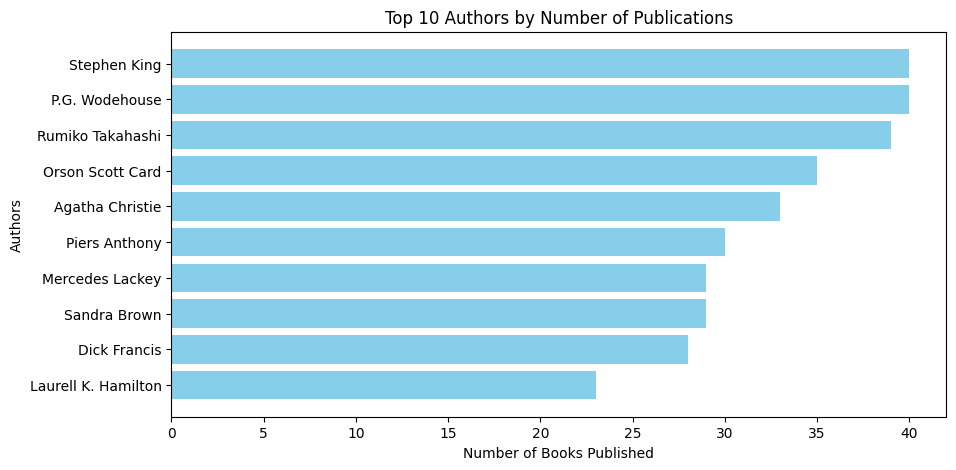

In [57]:
# Plot
plt.figure(figsize=(10, 5))
plt.barh(top_10_authors['authors'], top_10_authors['book_count'], color='skyblue')
plt.xlabel('Number of Books Published')
plt.ylabel('Authors')
plt.title('Top 10 Authors by Number of Publications')
plt.gca().invert_yaxis()  # Invert y-axis to show highest at the top
plt.show()


#### Among authors with multiple books, how do their average ratings vary, and are there authors with consistently high (or low) ratings?

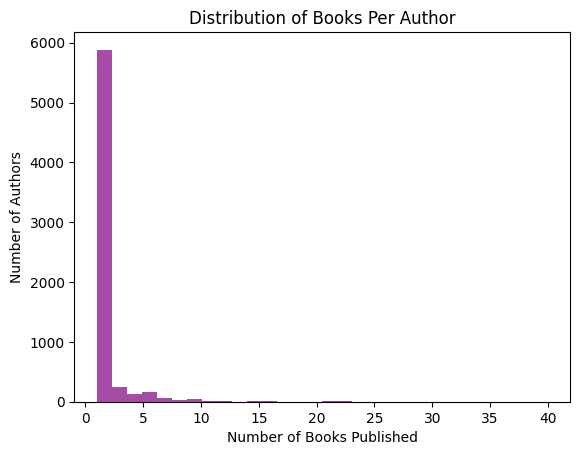

In [60]:
# Distribution of books
plt.hist(author_counts['book_count'], bins=30, color='purple', alpha=0.7)
plt.xlabel('Number of Books Published')
plt.ylabel('Number of Authors')
plt.title('Distribution of Books Per Author')
plt.show()


> Most of the authors have 1 or 2 books, **therefore we define 'authors with multiple books' as 'authors with 3 or more published books"**

In [61]:
# Calculating Average Rating Per Author
multi_book_authors = author_counts[author_counts['book_count'] >= 3]  # Adjust based on analysis

In [63]:
# calculating the mean rating per author:
author_avg_rating = df_cleaned.groupby('authors')['average_rating'].mean().reset_index()

In [64]:
author_analysis = multi_book_authors.merge(author_avg_rating, on='authors', how='left')

In [65]:
author_analysis.head()

,authors,book_count,average_rating
0,A.N. Roquelaure/Anne Rice,4,3.735000
1,Adam Hochschild,3,4.236667
2,Adrian McKinty,3,3.896667
3,Agatha Christie,33,3.989091
4,Agatha Christie/Hugh Fraser,5,3.822000


In [67]:
# Checking for highly consistent ratings
rating_variability = df_cleaned.groupby('authors')['average_rating'].std().reset_index()
author_analysis = author_analysis.merge(rating_variability, on='authors', how='left')
author_analysis.rename(columns={'average_rating_x': 'avg_rating', 'average_rating_y': 'rating_std'}, inplace=True)

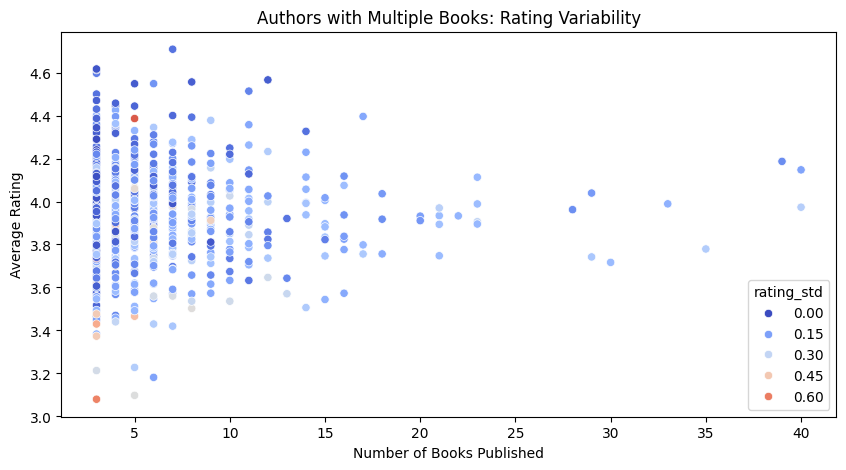

In [68]:
# Visualizations
plt.figure(figsize=(10, 5))
sns.scatterplot(data=author_analysis, x='book_count', y='avg_rating', hue='rating_std', palette='coolwarm')
plt.xlabel('Number of Books Published')
plt.ylabel('Average Rating')
plt.title('Authors with Multiple Books: Rating Variability')
plt.show()

> Most authors with multiple books (3+) have consistent ratings, with low variability (0 or 0.15 rating_std)!  
This indicates that readers tend to rate their works similarly. The few cases with higher rating variability (0.60) might be authors with diverse writing styles or books spanning different genres, leading to mixed reader feedback!  
The overall rating range of 3.0 to 4.6 suggests that books in the dataset are generally well-received, with few extremely low ratings! 